In [1]:
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix

import h5py
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.metrics import Metric
from tensorflow.keras import optimizers,regularizers
from keras.models import load_model

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = h5py.File('/content/drive/My Drive/Colab Notebooks/SVHN/SVHN_single_grey1.h5','r')
df.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [ ]:
x_train = df['X_train'][:]
y_train = df['y_train'][:]

x_test = df['X_test'][:]
y_test = df['y_test'][:]

In [ ]:
print("Shape of train set: "+str(x_train.shape))
print("Corresponding train set labels: "+str(y_train.shape))

print("")

print("Shape of test set: "+str(x_test.shape))
print("Corresponding test set labels: "+str(y_test.shape))

Shape of train set: (42000, 32, 32)
Corresponding train set labels: (42000,)

Shape of test set: (18000, 32, 32)
Corresponding test set labels: (18000,)


**Reshaping and Normalizing**

In [ ]:
x_train = x_train.reshape(42000, 32, 32, 1)
x_test = x_test.reshape(18000, 32, 32, 1)

# one-hot encoding target/labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("train set after reshaping: "+str(x_train.shape))
print("train set labels after reshaping: "+str(y_train.shape))

print("test set after reshaping: "+str(x_test.shape))
print("test set labels after reshaping: "+str(y_test.shape))

train set after reshaping: (42000, 32, 32, 1)
train set labels after reshaping: (42000, 10)
test set after reshaping: (18000, 32, 32, 1)
test set labels after reshaping: (18000, 10)


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

**Lets make a simple CNN architecture:**

In [ ]:
def cnn_model1(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False, ver_bose=True):

  model = tensorflow.keras.models.Sequential()

  # input:32x32x1
  # conv-32(with padding,filter3x3): 32x32x32
  # conv-32(with padding,filter3x3): 32x32x32
  # mp(2x2 with stride 2(default value is pool size)): 16x16x32
  model.add(Conv2D(32, (3, 3), name="conv32_relu_1", input_shape=(32, 32, 1), activation='relu', padding='same',kernel_initializer='he_normal'))
  model.add(Conv2D(32, (3, 3), name="conv32_relu_2", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size = (2, 2),name="mp1")) 

  # conv-64(with padding,filter3x3): 16x16x64
  # conv-64(with padding,filter3x3): 16x16x64
  # mp(2x2 with stride 2(default value is pool size)): 8x8x64
  model.add(Conv2D(64, (3, 3), name="conv64_relu_1", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(Conv2D(64, (3, 3), name="conv64_relu_2", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size = (2, 2),name="mp2")) 

  # 4096x1
  model.add(Flatten())

  #adding 1st fully connected layer with he_normal initialization
  model.add(Dense(4100, name="h1_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 2nd fully connected layer with he_normal initialization
  model.add(Dense(2050, name="h2_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, kernel_initializer='he_normal', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))
  model.add(Activation('softmax'))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
    val_batch = 16
  else:
    val=None
    val_batch = None
  
  if(ver_bose!=True):
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, verbose=0)
    print("model has been fitted.. evaluating on train and test set")
    score_train = model.evaluate(xtrain, ytrain, batch_size=16, verbose=0)
    score_test = model.evaluate(x_test, y_test, batch_size=16, verbose=0)

    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")

    return [model,score_train,score_test]
  else:
    model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, verbose=1)
    if(save_model_name!=False):
      model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
    return model



**lets see if we can overfit a subset of 20 images. No regularisation.**

In [ ]:
cnn_model = cnn_model1(xtrain=x_train[0:20], ytrain=y_train[0:20], epoch=500, batchsize=5, learn_rate=1e-3, l2_lambda=0)

Epoch 1/500
4/4 [==============================] - 0s 5ms/step - loss: 5.4612 - accuracy: 0.1500
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 2.3031 - accuracy: 0.4500
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 1.7350 - accuracy: 0.4500
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 2.0257 - accuracy: 0.4500
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 1.1115 - accuracy: 0.6500
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2829 - accuracy: 0.9500
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.8250 - accuracy: 0.6500
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.9555 - accuracy: 0.7500
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 0.1989 - accuracy: 1.0000
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 0.3077 - accuracy: 0.8500
Epoch 11/500
4/4 [===========

**Perhaps we can. Lets run for 100 epochs with learning rate and regularisation parameter of 1e-3:**

In [ ]:
%%time
cnn_model = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=100, batchsize=16, learn_rate=1e-3, l2_lambda=1e-3,validate=True)

Epoch 1/100
2625/2625 [==============================] - 25s 10ms/step - loss: 0.8204 - accuracy: 0.7535 - val_loss: 0.4406 - val_accuracy: 0.8688
Epoch 2/100
2625/2625 [==============================] - 25s 10ms/step - loss: 0.4326 - accuracy: 0.8711 - val_loss: 0.3753 - val_accuracy: 0.8912
Epoch 3/100
2625/2625 [==============================] - 26s 10ms/step - loss: 0.3430 - accuracy: 0.8989 - val_loss: 0.3236 - val_accuracy: 0.9107
Epoch 4/100
2625/2625 [==============================] - 25s 10ms/step - loss: 0.2803 - accuracy: 0.9180 - val_loss: 0.2915 - val_accuracy: 0.9218
Epoch 5/100
2625/2625 [==============================] - 25s 10ms/step - loss: 0.2308 - accuracy: 0.9368 - val_loss: 0.2970 - val_accuracy: 0.9208
Epoch 6/100
2625/2625 [==============================] - 26s 10ms/step - loss: 0.1836 - accuracy: 0.9495 - val_loss: 0.2818 - val_accuracy: 0.9321
Epoch 7/100
2625/2625 [==============================] - 26s 10ms/step - loss: 0.1506 - accuracy: 0.9593 - val_loss: 0

**Accuracy of 99.80% on training and Validation of accuracy of 93.08%. Lets visualize the training process:**

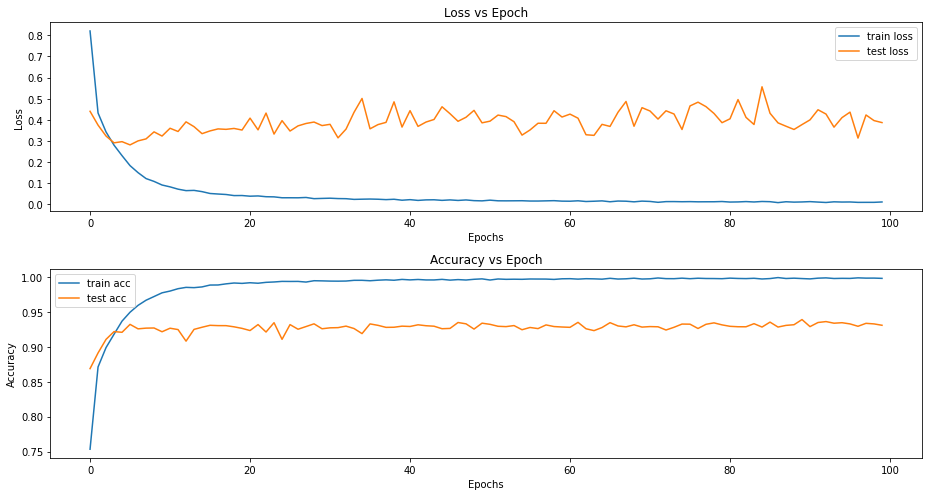

In [ ]:
loss = cnn_model.history.history['loss']
acc = cnn_model.history.history['accuracy']
val_loss = cnn_model.history.history['val_loss']
val_acc = cnn_model.history.history['val_accuracy']

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,100), loss, label="train loss")
axes[0].plot(range(0,100), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,100), acc, label="train acc")
axes[1].plot(range(0,100), val_acc, label="test acc")
axes[1].set_title("Accuracy vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

figure.show()
plt.tight_layout()

In [ ]:
cnn_model.evaluate(x_test,y_test,batch_size=16)

1125/1125 [==============================] - 3s 3ms/step - loss: 0.3872 - accuracy: 0.9308


[0.3872328996658325, 0.9308333396911621]

**Lets explore the learning rate. We will train for 20 epochs with a very small learning rate and regularization parameter of 1e-7:**

In [ ]:
cnn_model = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=16, learn_rate=1e-7, l2_lambda=1e-7)

Epoch 1/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.6856 - accuracy: 0.1040
Epoch 2/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.5051 - accuracy: 0.1217
Epoch 3/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.3712 - accuracy: 0.1517
Epoch 4/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.2556 - accuracy: 0.1884
Epoch 5/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.1658 - accuracy: 0.2255
Epoch 6/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.0855 - accuracy: 0.2624
Epoch 7/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2.0122 - accuracy: 0.3059
Epoch 8/20
2625/2625 [==============================] - 15s 6ms/step - loss: 1.9506 - accuracy: 0.3371
Epoch 9/20
2625/2625 [==============================] - 15s 6ms/step - loss: 1.8906 - accuracy: 0.3700
Epoch 10/20
2625/2625 [==============================] - 16s 6ms/step - l

**Again train for 20 epochs with a very large learning rate of 1e8:**

In [ ]:
cnn_model = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=16, learn_rate=1e8, l2_lambda=1e-7)

Epoch 1/20
2625/2625 [==============================] - 15s 6ms/step - loss: 46338754343862272.0000 - accuracy: 0.1000
Epoch 2/20
2625/2625 [==============================] - 15s 6ms/step - loss: 406936239472640.0000 - accuracy: 0.1020
Epoch 3/20
2625/2625 [==============================] - 15s 6ms/step - loss: 182595602087936.0000 - accuracy: 0.0984
Epoch 4/20
2625/2625 [==============================] - 15s 6ms/step - loss: 46232760221696.0000 - accuracy: 0.1014
Epoch 5/20
2625/2625 [==============================] - 15s 6ms/step - loss: 6089120153600.0000 - accuracy: 0.1008
Epoch 6/20
2625/2625 [==============================] - 15s 6ms/step - loss: 322397306880.0000 - accuracy: 0.0989
Epoch 7/20
2625/2625 [==============================] - 15s 6ms/step - loss: 2382059008.0000 - accuracy: 0.0985
Epoch 8/20
2625/2625 [==============================] - 15s 6ms/step - loss: 65384992.0000 - accuracy: 0.0970
Epoch 9/20
2625/2625 [==============================] - 15s 6ms/step - loss: 645

**Clearly 1e-7 is too low and 1e8 is too high. Lets meet in the middle at learning rate = 1e4:**

In [ ]:
cnn_model = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=20, batchsize=16, learn_rate=1e4, l2_lambda=1e-7)

Epoch 1/20
2625/2625 [==============================] - 15s 6ms/step - loss: 776939968.0000 - accuracy: 0.1002
Epoch 2/20
2625/2625 [==============================] - 15s 6ms/step - loss: 3940660.2500 - accuracy: 0.1017
Epoch 3/20
2625/2625 [==============================] - 15s 6ms/step - loss: 1999282.1250 - accuracy: 0.0981
Epoch 4/20
2625/2625 [==============================] - 15s 6ms/step - loss: 510580.3438 - accuracy: 0.0988
Epoch 5/20
2625/2625 [==============================] - 15s 6ms/step - loss: 53574.7773 - accuracy: 0.0982
Epoch 6/20
2625/2625 [==============================] - 15s 6ms/step - loss: 7487.2588 - accuracy: 0.0995
Epoch 7/20
2625/2625 [==============================] - 15s 6ms/step - loss: 6423.9214 - accuracy: 0.1002
Epoch 8/20
2625/2625 [==============================] - 15s 6ms/step - loss: 6462.0054 - accuracy: 0.0997
Epoch 9/20
2625/2625 [==============================] - 15s 6ms/step - loss: 6722.6826 - accuracy: 0.1007
Epoch 10/20
2625/2625 [=========

**Lets tune the learning rate:**

In [ ]:
%%time
import math
for k in range(1,15):

    lr = math.pow(10, np.random.uniform(-7.0, 3.0)) #lr between 1e-7 and 1e3
    lambdaa = math.pow(10, np.random.uniform(-7,-2)) #lamda between 1e-7 and 1e-2

    print("started...please wait")
    results = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=40, batchsize=16, learn_rate=lr, l2_lambda=lambdaa, ver_bose=False)
    print("Combination {0}/{1}: train_loss/acc: {2}, lr: {3}, Lambda: {4}".format(k, 14, results[1], lr, lambdaa))
    print("Combination {0}/{1}: test_loss/acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 14, results[2], lr, lambdaa))

    # results will return a list with 0th element as model, 1st as training loss&accuracy, 2nd as testing loss&accuracy

started...please wait
model has been fitted.. evaluating on train and test set
Combination 1/14: train_loss/acc: [0.0006071808165870607, 0.9999285936355591], lr: 4.207069336375341e-05, Lambda: 1.0210723457207304e-06
Combination 1/14: test_loss/acc: [0.5105326175689697, 0.9169999957084656], lr: 4.207069336375341e-05, Lambda: 1.0210723457207304e-06

started...please wait
model has been fitted.. evaluating on train and test set
Combination 2/14: train_loss/acc: [0.02937176823616028, 0.9933809638023376], lr: 0.019822598578679244, Lambda: 2.6751735028117878e-05
Combination 2/14: test_loss/acc: [0.6485690474510193, 0.8926110863685608], lr: 0.019822598578679244, Lambda: 2.6751735028117878e-05

started...please wait
model has been fitted.. evaluating on train and test set
Combination 3/14: train_loss/acc: [48.925987243652344, 0.09990476071834564], lr: 270.2087418696199, Lambda: 0.00047163727235964006
Combination 3/14: test_loss/acc: [49.04399871826172, 0.10022222250699997], lr: 270.20874186961

**The following combinations gave the best results:**
- combination 1/14 - lr = 4e-5, reg = 1e-6
- combination 4/14 - lr = 4e-4, reg = 4e-4
- combination 10/14 - lr = 1e-2, reg = 3e-6
- combination 11/14 - lr = 2e-4, reg = 3e-7
- combination 12/14 - lr = 1e-4, reg = 3e-3

**Lets fine tune:**

In [ ]:
%%time
import math
for k in range(1,8):

    lr = math.pow(10, np.random.uniform(-5.0, -2.0)) #lr between 1e-5 and 1e-2
    lambdaa = math.pow(10, np.random.uniform(-7,-3)) #lamda between 1e-7 and 1e-3

    print("started...please wait")
    results = cnn_model1(xtrain=x_train, ytrain=y_train, epoch=40, batchsize=16, learn_rate=lr, l2_lambda=lambdaa, ver_bose=False)
    print("Combination {0}/{1}: train_loss/acc: {2}, lr: {3}, Lambda: {4}".format(k, 7, results[1], lr, lambdaa))
    print("Combination {0}/{1}: test_loss/acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 7, results[2], lr, lambdaa))

    # results will return a list with 0th element as model, 1st as training loss&accuracy, 2nd as testing loss&accuracy

started...please wait
model has been fitted.. evaluating on train and test set
Combination 1/7: train_loss/acc: [0.0013699490809813142, 0.9996190667152405], lr: 0.0003266595824605301, Lambda: 2.1720429607438636e-07
Combination 1/7: test_loss/acc: [0.6025332808494568, 0.933388888835907], lr: 0.0003266595824605301, Lambda: 2.1720429607438636e-07

started...please wait
model has been fitted.. evaluating on train and test set
Combination 2/7: train_loss/acc: [0.0006325661670416594, 0.9999523758888245], lr: 2.2351511214103974e-05, Lambda: 4.3559871952492487e-07
Combination 2/7: test_loss/acc: [0.5211016535758972, 0.9047777652740479], lr: 2.2351511214103974e-05, Lambda: 4.3559871952492487e-07

started...please wait
model has been fitted.. evaluating on train and test set
Combination 3/7: train_loss/acc: [0.002404059749096632, 0.9998095035552979], lr: 3.1826563163347576e-05, Lambda: 2.761668374245445e-05
Combination 3/7: test_loss/acc: [0.5453875660896301, 0.9046111106872559], lr: 3.182656316

**Combination 1/14 - lr = 3e-4, reg = 2e-7 gave the best result hence we choose this to be the final learning rate and regularisation.**

###### We will now train for longer training session. 700 epochs. But this time we will add early stopping and ReduceLROnPlateau to avoid overfitting. <br><br>- Early Stopping: If training loss will not change by 0.01 for 50 epochs we will stop the training.<br><br>- ReduceLROnPlateau: if validation accuracy doesnt change by 0.01 for 15 epochs we will keep reducing the learning rate by 0.1 (10%) and will stop reducing once it reaches 1e-7<br>
Same model as before... just adding the code for Early Stopping and ReduceLROnPlateau:

In [ ]:
def cnn_model2(xtrain, ytrain, epoch, batchsize, learn_rate, l2_lambda, validate=False, save_model_name=False):

  model = tensorflow.keras.models.Sequential()

  # input:32x32x1
  # conv-32(with padding,filter3x3): 32x32x32
  # conv-32(with padding,filter3x3): 32x32x32
  # mp(2x2 with stride 2(default value is pool size)): 16x16x32
  model.add(Conv2D(32, (3, 3), name="conv32_relu_1", input_shape=(32, 32, 1), activation='relu', padding='same',kernel_initializer='he_normal'))
  model.add(Conv2D(32, (3, 3), name="conv32_relu_2", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size = (2, 2),name="mp1")) 

  # conv-64(with padding,filter3x3): 16x16x64
  # conv-64(with padding,filter3x3): 16x16x64
  # mp(2x2 with stride 2(default value is pool size)): 8x8x64
  model.add(Conv2D(64, (3, 3), name="conv64_relu_1", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(Conv2D(64, (3, 3), name="conv64_relu_2", activation = 'relu', padding = 'same',kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size = (2, 2),name="mp2")) 

  # 4096x1
  model.add(Flatten())

  #adding 1st fully connected layer with he_normal initialization
  model.add(Dense(4100, name="h1_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding 2nd fully connected layer with he_normal initialization
  model.add(Dense(2050, name="h2_relu", kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  #adding output layers with 10 units since we have 10 target labels
  model.add(Dense(10, kernel_initializer='he_normal', name="output_layer_softmax", kernel_regularizer=regularizers.l2(l2_lambda)))
  model.add(Activation('softmax'))

  adam = optimizers.Adam(lr = learn_rate)
  model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

  if(validate==True):
    val = (x_test,y_test)
    val_batch = 10
  else:
    val=None
    val_batch = None


  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=50, verbose=1, mode='min', restore_best_weights=True)
  change_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, verbose=1, mode='max', min_delta=0.01, cooldown=5, min_lr=3*1e-7)
  model.fit(xtrain, ytrain, epochs=epoch, batch_size=batchsize, validation_data=val, validation_batch_size=val_batch, callbacks=[early_stop,change_lr], verbose=1)
  
  if(save_model_name!=False):
    model.save("/content/drive/My Drive/Colab Notebooks/"+save_model_name+".h5")
    
  return model



In [ ]:
cnn_model = cnn_model2(xtrain=x_train, ytrain=y_train, epoch=700, batchsize=10, learn_rate=3*1e-4, l2_lambda=2*1e-7, validate=True, save_model_name="cnn_model")

Epoch 1/700
4200/4200 [==============================] - 40s 10ms/step - loss: 0.8493 - accuracy: 0.7354 - val_loss: 0.3952 - val_accuracy: 0.8794
Epoch 2/700
4200/4200 [==============================] - 39s 9ms/step - loss: 0.4396 - accuracy: 0.8671 - val_loss: 0.3097 - val_accuracy: 0.9109
Epoch 3/700
4200/4200 [==============================] - 39s 9ms/step - loss: 0.3311 - accuracy: 0.8999 - val_loss: 0.2686 - val_accuracy: 0.9222
Epoch 4/700
4200/4200 [==============================] - 40s 9ms/step - loss: 0.2526 - accuracy: 0.9216 - val_loss: 0.3080 - val_accuracy: 0.9184
Epoch 5/700
4200/4200 [==============================] - 39s 9ms/step - loss: 0.2038 - accuracy: 0.9365 - val_loss: 0.2991 - val_accuracy: 0.9246
Epoch 6/700
4200/4200 [==============================] - 39s 9ms/step - loss: 0.1586 - accuracy: 0.9505 - val_loss: 0.2895 - val_accuracy: 0.9268
Epoch 7/700
4200/4200 [==============================] - 39s 9ms/step - loss: 0.1315 - accuracy: 0.9572 - val_loss: 0.3230 

**With early stopping the training stopped at 88 epochs with a validation accuracy of 94.57%. Remember in previous part (svhn without CNN) we achieved the best validation accuracy of 90.62% with a 6 layer classifier with batchnorm layer after every layer and a huge training time.**<br><br>Lets save the model and model history:  

In [ ]:
hist_df = pd.DataFrame(cnn_model.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/cnn_model_history.csv',index=False)

Loading model and model history:

In [ ]:
cnn_model = load_model("/content/drive/My Drive/Colab Notebooks/cnn_model.h5")
hist_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cnn_model_history.csv')

**Lets see the training process:**

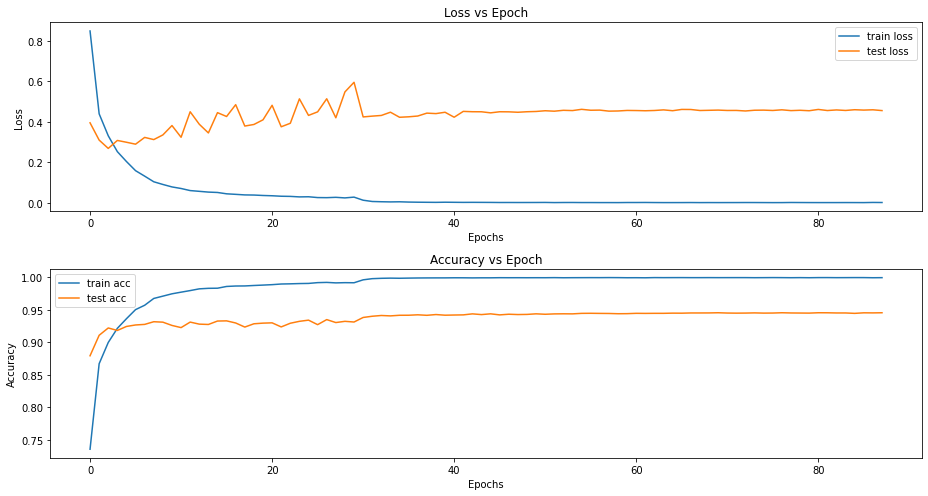

In [ ]:
loss = hist_df['loss']
acc = hist_df['accuracy']
val_loss = hist_df['val_loss']
val_acc = hist_df['val_accuracy']
epoch = hist_df.shape[0]

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 7))

axes[0].plot(range(0,epoch), loss, label="train loss")
axes[0].plot(range(0,epoch), val_loss, label="test loss")
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(range(0,epoch), acc, label="train acc")
axes[1].plot(range(0,epoch), val_acc, label="test acc")
axes[1].set_title("Accuracy vs Epoch")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

figure.show()
plt.tight_layout()

**Lets see how the learning rate changed:**

3.000000e-04    30
3.000000e-05    24
3.000000e-06    19
3.000000e-07    15
Name: lr, dtype: int64



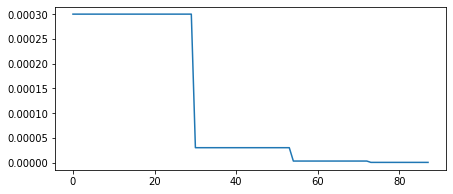

In [ ]:
print(hist_df["lr"].value_counts())
print("")

plt.figure(figsize=(7, 3))
plt.plot(range(0,epoch), hist_df["lr"])
plt.show()

In [ ]:
cnn_model.evaluate(x_test,y_test,batch_size=10)

1800/1800 [==============================] - 5s 3ms/step - loss: 0.4431 - accuracy: 0.9417


[0.44306129217147827, 0.9417222142219543]

**Classification report and confusion matrix:**

In [ ]:
y_pred = np.argmax(cnn_model.predict(x_test), axis=1)
y_true = np.argmax(y_test,axis=1)

print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_true, y_pred=y_pred))
print("")

print("CONFUSION MATRIX")
mat_train = confusion_matrix(y_true,y_pred)
idx=range(10)
df_cm = pd.DataFrame(mat_train, index=["truth "+str(i) for i in idx], columns=["predicted "+str(i) for i in idx])
df_cm

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1814
           1       0.94      0.94      0.94      1828
           2       0.96      0.94      0.95      1803
           3       0.94      0.92      0.93      1719
           4       0.94      0.96      0.95      1812
           5       0.94      0.94      0.94      1768
           6       0.94      0.93      0.93      1832
           7       0.94      0.96      0.95      1808
           8       0.94      0.93      0.94      1812
           9       0.94      0.92      0.93      1804

    accuracy                           0.94     18000
   macro avg       0.94      0.94      0.94     18000
weighted avg       0.94      0.94      0.94     18000


CONFUSION MATRIX


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7,predicted 8,predicted 9
truth 0,1752,8,2,2,4,3,13,9,8,13
truth 1,12,1715,11,16,25,3,5,24,12,5
truth 2,11,6,1701,8,12,2,5,26,12,20
truth 3,5,17,11,1579,11,38,14,17,12,15
truth 4,8,20,9,8,1733,5,7,6,5,11
truth 5,2,7,4,33,6,1666,29,3,8,10
truth 6,21,7,6,5,10,35,1705,8,29,6
truth 7,3,22,6,16,10,1,2,1738,2,8
truth 8,15,18,7,9,11,10,33,2,1694,13
truth 9,35,14,10,12,14,15,8,16,12,1668


**We also have a validation set. Lets see how we performed on this set. In previous part we achieved 97% on this set.**

In [ ]:
xval = df['X_val'][:]
yval = df['y_val'][:]
x_val = xval.reshape(60000, 32, 32, 1)
y_val = to_categorical(yval, num_classes=10)

x_val = x_val.astype('float32')
x_val /= 255

cnn_model.evaluate(x_val,y_val,batch_size=10)

6000/6000 [==============================] - 16s 3ms/step - loss: 0.1330 - accuracy: 0.9825


[0.13297511637210846, 0.9825166463851929]

**In this part we achieve 98.25%.** Lets see the classification report and confusion matrix:

In [ ]:
y_pred = np.argmax(cnn_model.predict(x_val), axis=1)
y_true = np.argmax(y_val,axis=1)

print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_true, y_pred=y_pred))
print("")

print("CONFUSION MATRIX")
mat_train = confusion_matrix(y_true,y_pred)
idx=range(10)
df_cm = pd.DataFrame(mat_train, index=["truth "+str(i) for i in idx], columns=["predicted "+str(i) for i in idx])
df_cm

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6000
           1       0.98      0.98      0.98      6000
           2       0.99      0.98      0.99      6000
           3       0.98      0.98      0.98      6000
           4       0.98      0.99      0.98      6000
           5       0.98      0.98      0.98      6000
           6       0.98      0.98      0.98      6000
           7       0.98      0.99      0.98      6000
           8       0.98      0.98      0.98      6000
           9       0.98      0.98      0.98      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000


CONFUSION MATRIX


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7,predicted 8,predicted 9
truth 0,5938,8,2,2,4,3,13,9,8,13
truth 1,12,5887,11,16,25,3,5,24,12,5
truth 2,11,6,5898,8,12,2,5,26,12,20
truth 3,5,17,11,5860,11,38,14,17,12,15
truth 4,8,20,9,8,5921,5,7,6,5,11
truth 5,2,7,4,33,6,5898,29,3,8,10
truth 6,21,7,6,5,10,35,5873,8,29,6
truth 7,3,22,6,16,10,1,2,5930,2,8
truth 8,15,18,7,9,11,10,33,2,5882,13
truth 9,35,14,10,12,14,15,8,16,12,5864


**Lets see how the model architecture looks like:**

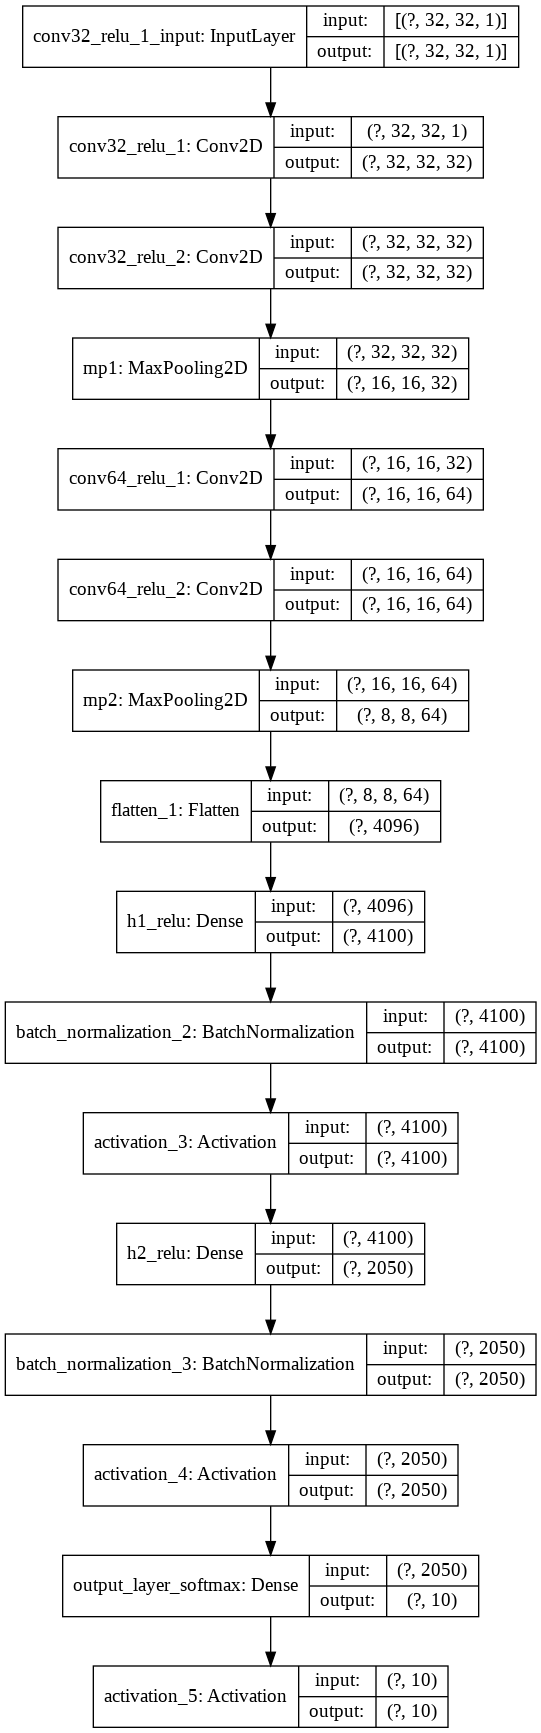

In [ ]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

# In this part we saw how a simple CNN model surpassed the complicated model we created in the previous part with 6 fully connected layers. This model was much faster to train. The accuracy and loss converged at just 88 epochs while in previous part we trained upto 338 epochs.